<a href="https://www.kaggle.com/code/skasikilahi/heart-disease-prediction?scriptVersionId=181250344" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Loading DataSet**

2024-06-03 11:12:56.168331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 11:12:56.168427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 11:12:56.279028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


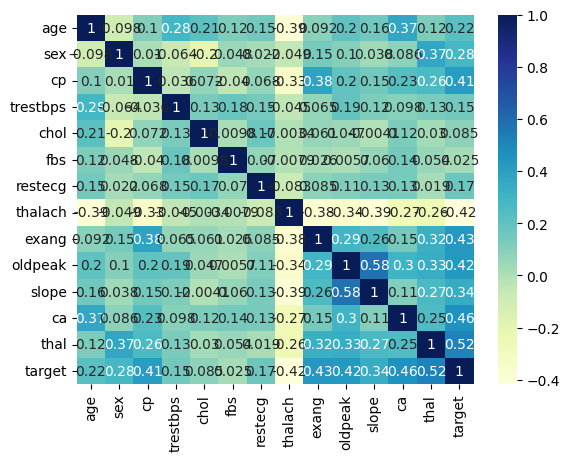

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization


data = pd.read_csv('/kaggle/input/heart-disease-cleveland/Heart_disease_cleveland_new.csv')
# print(data)
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [3]:
X = data.drop('target', axis=1)
y = data['target']

# Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)


# # print(X_train_reshaped)
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# # print(X_train)
# # Reshape data for RNN input (assuming we want to treat each feature as a time step)
# X_train_scaled_reshaped = X_train_scaled.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
# X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the scaled set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

# Reshape data for RNN input
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))


X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Display the first few rows of the reshaped data
# print("Unscaled Data Reshaped:")
# print(X_train_unscaled_reshaped[:5])
# print("\nScaled Data Reshaped:")
# print(X_train_scaled_reshaped[:5])

ELM

In [4]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size = 1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w = np.random.uniform(-1,1,(input_size, hidden_size))
        self.b = np.random.uniform(-1,1,hidden_size)
        self.beta = None
        self.H = None
        self.activation_function = None
    

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)  
        return 1 / (1 + np.exp(-x))

    
    def relu(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        x = np.clip(x, -500, 500)
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def fit(self, X, t,activation_function):
        self.activation_function = activation_function
        if activation_function == 'relu':
            self.H = self.relu(np.dot(X, self.w) + self.b)
        elif activation_function == 'sigmoid':
            self.H = self.sigmoid(np.dot(X, self.w) + self.b)
        elif activation_function == 'softmax':
            self.H = self.softmax(np.dot(X, self.w) + self.b)
        self.beta = np.dot(np.linalg.pinv(self.H), t)
        
    def predict(self, X):
        if self.activation_function == 'relu':
            H = self.relu(np.dot(X, self.w) + self.b)
        elif self.activation_function == 'sigmoid':
            H = self.sigmoid(np.dot(X, self.w) + self.b)
        elif self.activation_function == 'softmax':
            H = self.softmax(np.dot(X, self.w) + self.b)
        return np.dot(H, self.beta)
        

In [5]:
from sklearn.metrics import accuracy_score
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.1, random_state=42)

max_acc = 0
at_inp_size = 0

scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)



for i in range(5,1000,5):
    elm  = ELM(X_train_1.shape[1],i)
    elm.fit(X_train_1 , y_train_1 , activation_function = 'sigmoid')
    z = np.where(elm.predict(X_test_1) >= 0.5,1,0)
    a = accuracy_score(y_test_1, z)
    if a > max_acc:
        max_acc = a
        at_inp_size = i
print(f"Test Accuracy: {max_acc * 100:.2f}% for number of hidden nodes {at_inp_size} using sigmoid")




max_acc = 0
for i in range(5,1000,5):
    elm  = ELM(X_train_1.shape[1],i)
    elm.fit(X_train_1 , y_train_1 , activation_function = 'relu')
    z = np.where(elm.predict(X_test_1) >= 0.5,1,0)
    a = accuracy_score(y_test_1, z)
    if a > max_acc:
        max_acc = a
        at_inp_size = i
print(f"Test Accuracy: {max_acc * 100:.2f}% for number of hidden nodes {at_inp_size} using relu")




max_acc = 0
for i in range(5,1000,5):
    elm  = ELM(X_train_1.shape[1],i)
    elm.fit(X_train_1 , y_train_1 , activation_function = 'softmax')
    z = elm.predict(X_test_1)
    z = np.where(z >= 0.5,1,0)
    a = accuracy_score(y_test_1, z)
    if a > max_acc:
        max_acc = a
        at_inp_size = i
print(f"Test Accuracy: {max_acc * 100:.2f}% for number of hidden nodes {at_inp_size} using softmax")
# print(accuracy_score(y_test, z))

Test Accuracy: 96.77% for number of hidden nodes 590 using sigmoid
Test Accuracy: 96.77% for number of hidden nodes 755 using relu
Test Accuracy: 93.55% for number of hidden nodes 100 using softmax


**LSTM**

In [6]:
# model = Sequential([
#     LSTM(128, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.2),
#     LSTM(128),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

LSTM_model = Sequential([
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(256),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score

# # Define a function to create and compile the model
# def create_model(units=128, dropout_rate=0.2, learning_rate=1e-4):
#     model = Sequential([
#         LSTM(units, return_sequences=True),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         LSTM(units),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define hyperparameters to search
# param_grid = {
#     'units': [128, 256],
#     'dropout_rate': [0.2, 0.3],
#     'learning_rate': [1e-4, 5e-5]
# }

# best_accuracy = 0
# best_params = {}

# # Iterate over hyperparameters
# for units in param_grid['units']:
#     for dropout_rate in param_grid['dropout_rate']:
#         for learning_rate in param_grid['learning_rate']:
#             # Create and compile the model
#             model = create_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)
            
#             # Train the model
#             model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
            
#             # Evaluate on validation data
#             y_pred = model.predict(X_train_reshaped)
#             val_accuracy = accuracy_score(y_val, y_pred)
            
#             # Update best parameters if validation accuracy improves
#             if val_accuracy > best_accuracy:
#                 best_accuracy = val_accuracy
#                 best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

# # Create and compile the best model
# best_model = create_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'],
#                           learning_rate=best_params['learning_rate'])

# # Train the best model on the combined training and validation data
# best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# # Evaluate the best model on test data
# y_pred_test = best_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# print(f'Best Parameters: {best_params}')
# print(f'Test Accuracy: {test_accuracy}')


In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)

In [8]:

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
LSTM_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5876 - loss: 0.8053 - val_accuracy: 0.4286 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6438 - loss: 0.9510 - val_accuracy: 0.4286 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7672 - loss: 0.6023 - val_accuracy: 0.5714 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7095 - loss: 0.6002 - val_accuracy: 0.7551 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7516 - loss: 0.5803 - val_accuracy: 0.4286 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7488 - loss: 0.5530 - val_accuracy: 0.4286 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7724 - loss: 0.6554 - val_accuracy: 0.428

In [10]:
y_pred_proba = LSTM_model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)  

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


In [11]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
X_test_df = pd.DataFrame(X_test.values, columns=X_test.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
# print(y_test,y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Accuracy: 49.18%
Precision: 1.00
Recall: 0.03
F1-Score: 0.06
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0    0.0  3

**BAYESIAN CLASSIFICATION**

In [12]:
from sklearn.naive_bayes import GaussianNB
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, y, test_size=0.5, random_state=50)

nb_classifier = GaussianNB()
nb_classifier.fit(X_train_g, y_train_g)
y_pred_g = nb_classifier.predict(X_test_g)
accuracy = accuracy_score(y_test_g, y_pred_g)
precision = precision_score(y_test_g, y_pred_g)
recall = recall_score(y_test_g, y_pred_g)
f1 = f1_score(y_test_g, y_pred_g)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
X_test_df = pd.DataFrame(X_test_g.values, columns=X_test_g.columns)
y_test_df = pd.DataFrame(y_test_g.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_g, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Accuracy: 86.18%
Precision: 0.92
Recall: 0.78
F1-Score: 0.84
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  52.0  1.0  0.0     118.0  186.0  0.0      2.0    190.0    0.0      0.0   
1  54.0  0.0  2.0     135.0  304.0  1.0      0.0    170.0    0.0      0.0   
2  61.0  1.0  3.0     140.0  207.0  0.0      2.0    138.0    1.0      1.9   
3  61.0  1.0  2.0     150.0  243.0  1.0      0.0    137.0    1.0      1.0   
4  39.0  0.0  2.0     138.0  220.0  0.0      0.0    152.0    0.0      0.0   
5  55.0  0.0  3.0     180.0  327.0  0.0      1.0    117.0    1.0      3.4   
6  57.0  0.0  3.0     140.0  241.0  0.0      0.0    123.0    1.0      0.2   
7  52.0  1.0  1.0     134.0  201.0  0.0      0.0    158.0    0.0      0.8   
8  49.0  0.0  3.0     130.0  269.0  0.0      0.0    163.0    0.0      0.0   
9  46.0  0.0  2.0     142.0  177.0  0.0      2.0    160.0    1.0      1.4   

   slope   ca  thal  Actual  Predicted  
0    1.0  0

RNN

In [13]:
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# X_train_reshaped_RNN = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
# X_test_reshaped_RNN = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Define the SimpleRNN model with more layers
# model1 = Sequential([
#     SimpleRNN(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=True),
#     Dropout(0.5),
#     SimpleRNN(256, activation='tanh', return_sequences=True),
#     Dropout(0.5),
#     SimpleRNN(256, activation='tanh'),
#     Dropout(0.5),
#     Dense(128, activation='tanh'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])
model1 = Sequential([
SimpleRNN(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    SimpleRNN(256, activation='tanh', return_sequences=True),
    Dropout(0.5),
    SimpleRNN(256, activation='tanh'),
    Dropout(0.5),
    Dense(128, activation='tanh'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model1.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
_, accuracy = model1.evaluate(X_test_reshaped, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.5625 - loss: 0.7829

I0000 00:00:1717413249.858162      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717413249.894933      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5930 - loss: 0.7788 - val_accuracy: 0.6735 - val_loss: 0.5767
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6788 - loss: 0.6872 - val_accuracy: 0.6735 - val_loss: 0.6602
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6258 - loss: 0.7599 - val_accuracy: 0.7143 - val_loss: 0.5500
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6757 - loss: 0.6586 - val_accuracy: 0.7551 - val_loss: 0.5188
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6289 - loss: 0.7008 - val_accuracy: 0.7143 - val_loss: 0.5344
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6289 - loss: 0.7995 - val_accuracy: 0.7551 - val_loss: 0.5158
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5852 - loss: 0.7663 - val_accuracy: 0.5714 - val_loss: 0.6695
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6174 - loss: 0.7174 - val_accuracy: 0.7551 - val_loss: 0.5024
Epoch 9/50
4

In [15]:
import tensorflow as tf
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
y_pred_proba = model1.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
X_test_df = pd.DataFrame(X_test.values, columns=X_test.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Shape of X_test_reshaped: (61, 13, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 745ms/step
Accuracy: 80.33%
Precision: 0.88
Recall: 0.72
F1-Score: 0.79
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    1

In [16]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Reshape the input data for SimpleRNN
# X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [17]:
from keras.layers import Input
from keras.models import Model


input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
inputs = Input(shape=input_shape)

x = SimpleRNN(256, activation='relu', return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = SimpleRNN(256, activation='relu', return_sequences=True)(x)
x = Dropout(0.5)(x)
x = SimpleRNN(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=inputs, outputs=outputs)
# model1 = Sequential([
#     SimpleRNN(256, input_shape=(1, X_train_scaled.shape[1]), activation='relu', return_sequences=True),
#     Dropout(0.5),
#     SimpleRNN(256, activation='relu', return_sequences=True),
#     Dropout(0.5),
#     SimpleRNN(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

In [18]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs and batch size
model2.fit(X_train_scaled_reshaped, y_train, epochs=50, batch_size=128, validation_split=0.2)

# Evaluate the model on the test set
_, accuracy = model2.evaluate(X_test_scaled_reshaped, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4453 - loss: 0.7209

W0000 00:00:1717413274.039435      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.4870 - loss: 0.7061 - val_accuracy: 0.6939 - val_loss: 0.6508
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5995 - loss: 0.6566 - val_accuracy: 0.7755 - val_loss: 0.5916
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6288 - loss: 0.6420 - val_accuracy: 0.8367 - val_loss: 0.5328
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7232 - loss: 0.5675 - val_accuracy: 0.7959 - val_loss: 0.4691
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8011 - loss: 0.5379 - val_accuracy: 0.7755 - val_loss: 0.4470
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6790 - loss: 0.6026 - val_accuracy: 0.7551 - val_loss: 0.4532
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7526 - loss: 0.4713 - val_accuracy: 0.7347 - val_loss: 0.4511
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7976 - loss: 0.5104 - val_accuracy: 0.7959 - val_loss: 0.4543
Epoch 9/50
2

In [19]:
y_pred_proba = model2.predict(X_test_scaled_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


In [20]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X_test.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Accuracy: 85.25%
Precision: 0.85
Recall: 0.88
F1-Score: 0.86
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0    0.0  3

In [21]:
from sklearn.linear_model import LinearRegression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_binary, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Accuracy: 88.52%
Precision: 0.88
Recall: 0.91
F1-Score: 0.89
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0    0.0  3

**Radial Basis Function Network**

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from xgboost import XGBClassifier

In [23]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# print(y_test)

In [24]:
rbfn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', max_iter=1000)
rbfn_model.fit(X_train_scaled, y_train)
y_pred_rbfn = rbfn_model.predict(X_test_scaled)
accuracy_rbfn = accuracy_score(y_test, y_pred_rbfn)
print(f'RBFN Accuracy: {accuracy_rbfn * 100:.2f}%')
precision = precision_score(y_test, y_pred_rbfn)
recall = recall_score(y_test, y_pred_rbfn)
f1 = f1_score(y_test, y_pred_rbfn)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_rbfn, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

RBFN Accuracy: 83.61%
Precision: 0.81
Recall: 0.91
F1-Score: 0.85
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0    0

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


**RANDOM FORREST**

In [25]:
rf_model = RandomForestClassifier(n_estimators=10000, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf * 100:.2f}%')

precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_rf, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

Random Forest Accuracy: 88.52%
Precision: 0.93
Recall: 0.84
F1-Score: 0.89
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted

**SVR** 

In [26]:

svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
y_pred_svr_binary = (y_pred_svr >= 0.5).astype(int)
accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
print(f'SVR Accuracy: {accuracy_svr * 100:.2f}%')
precision = precision_score(y_test, y_pred_svr_binary)
recall = recall_score(y_test, y_pred_svr_binary)
f1 = f1_score(y_test, y_pred_svr_binary)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_svr_binary, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

SVR Accuracy: 95.08%
Precision: 0.94
Recall: 0.97
F1-Score: 0.95
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0    0.

In [27]:

xgb_model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=1000,
    random_state=50
)
# xgb_model = XGBClassifier(random_state=50)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb * 100:.2f}%')
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
# X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test.values, columns=X.columns)
y_test_df = pd.DataFrame(y_test.values, columns=['Actual'])
y_pred_df = pd.DataFrame(y_pred_xgb, columns=['Predicted'])
results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)
print("Data with Actual and Predicted Labels:")
print(results_df.head(10))

XGBoost Accuracy: 85.25%
Precision: 0.90
Recall: 0.81
F1-Score: 0.85
Data with Actual and Predicted Labels:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  53.0  1.0  2.0     130.0  246.0  1.0      2.0    173.0    0.0      0.0   
1  54.0  1.0  3.0     110.0  206.0  0.0      2.0    108.0    1.0      0.0   
2  56.0  1.0  3.0     125.0  249.0  1.0      2.0    144.0    1.0      1.2   
3  58.0  1.0  3.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
4  51.0  0.0  3.0     130.0  305.0  0.0      0.0    142.0    1.0      1.2   
5  53.0  1.0  3.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
6  65.0  1.0  3.0     135.0  254.0  0.0      2.0    127.0    0.0      2.8   
7  53.0  1.0  3.0     123.0  282.0  0.0      0.0     95.0    1.0      2.0   
8  40.0  1.0  3.0     152.0  223.0  0.0      0.0    181.0    0.0      0.0   
9  59.0  1.0  3.0     135.0  234.0  0.0      0.0    161.0    0.0      0.5   

   slope   ca  thal  Actual  Predicted  
0  